In [48]:
# ARIMA model for German stock price data

### importing all required libraries

In [49]:
import pandas                             as      pd
import numpy                              as      np
import matplotlib.pyplot                  as      plt
import seaborn                            as      sns
from   IPython.display                    import  display
from   pylab                              import  rcParams 
from   datetime                           import  datetime, timedelta
from statsmodels.tsa.stattools            import  adfuller
from statsmodels.tsa.stattools            import  pacf
from statsmodels.tsa.stattools            import  acf
from statsmodels.graphics.tsaplots        import  plot_pacf
from statsmodels.graphics.tsaplots        import  plot_acf
from statsmodels.graphics.gofplots        import  qqplot
from statsmodels.tsa.seasonal             import  seasonal_decompose
from statsmodels.tsa.arima_model          import  ARIMA
from statsmodels.tsa.statespace.sarimax   import  SARIMAX
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [50]:
df=pd.read_csv('StockPrice.csv')

In [51]:
df.head()

,Year,Month,Price
0,1981,Jan,67.27
1,1981,Feb,65.86
2,1981,Mar,70.80
3,1981,Apr,72.38
4,1981,May,70.61


In [52]:
df.tail()

,Year,Month,Price
151,1993,Aug,255.42
152,1993,Sep,252.51
153,1993,Oct,267.58
154,1993,Nov,270.85
155,1993,Dec,286.34


In [54]:
date = pd.date_range(start='01/01/1981', end='12/31/1993', freq='M')

In [55]:
date

DatetimeIndex(['1981-01-31', '1981-02-28', '1981-03-31', '1981-04-30',
               '1981-05-31', '1981-06-30', '1981-07-31', '1981-08-31',
               '1981-09-30', '1981-10-31',
               ...
               '1993-03-31', '1993-04-30', '1993-05-31', '1993-06-30',
               '1993-07-31', '1993-08-31', '1993-09-30', '1993-10-31',
               '1993-11-30', '1993-12-31'],
              dtype='datetime64[ns]', length=156, freq='M')

In [56]:
df['TimeStamp']=pd.DataFrame(date,columns=['Date'])
df_model = df.set_index('TimeStamp')
df_model.head()

,Year,Month,Price
TimeStamp,,,
1981-01-31,1981,Jan,67.27
1981-02-28,1981,Feb,65.86
1981-03-31,1981,Mar,70.80
1981-04-30,1981,Apr,72.38
1981-05-31,1981,May,70.61


In [57]:
df.shape

(156, 4)

In [58]:
df.head()


,Year,Month,Price,TimeStamp
0,1981,Jan,67.27,1981-01-31
1,1981,Feb,65.86,1981-02-28
2,1981,Mar,70.80,1981-03-31
3,1981,Apr,72.38,1981-04-30
4,1981,May,70.61,1981-05-31


In [59]:
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
df_model = df.set_index('TimeStamp')
df_model.head()

,Year,Month,Price
TimeStamp,,,
1981-01-31,1981,Jan,67.27
1981-02-28,1981,Feb,65.86
1981-03-31,1981,Mar,70.80
1981-04-30,1981,Apr,72.38
1981-05-31,1981,May,70.61


In [60]:
df_model=df_model.drop(['Year','Month'],axis=1)
df_model.head()

,Price
TimeStamp,
1981-01-31,67.27
1981-02-28,65.86
1981-03-31,70.80
1981-04-30,72.38
1981-05-31,70.61


### plotting time series

In [61]:
df_model.head()

,Price
TimeStamp,
1981-01-31,67.27
1981-02-28,65.86
1981-03-31,70.80
1981-04-30,72.38
1981-05-31,70.61


### cheking for NA values

In [62]:
df_model.isna().value_counts()

Price
False    156
dtype: int64

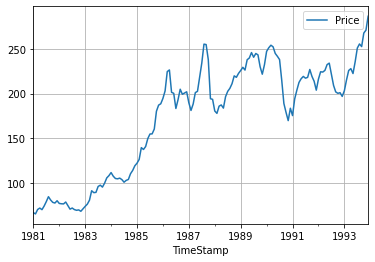

In [63]:
df_model.plot(grid=True);

# applying Adfuller test to confirm the same

In [64]:
observations= df_model.values
test_result = adfuller(observations)

In [65]:
test_result

(-1.1131190500133705,
 0.7098119246873354,
 1,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1016.3730589901897)

In [66]:
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])
print('Critical Values:')
for key, value in test_result[4].items():
	print('\t%s: %.5f' % (key, value))

ADF Statistic: -1.113119
p-value: 0.709812
Critical Values:
	1%: -3.47354
	5%: -2.88050
	10%: -2.57688


In [67]:
### test results confirms that the series is non-stationary

In [68]:
df_diff = df_model.diff(periods=1).dropna()


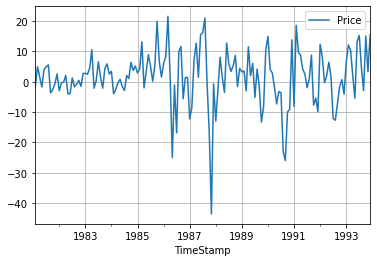

In [69]:
df_diff.plot(grid=True);

In [70]:
observations= df_diff.values
test_result = adfuller(observations)
test_result

(-8.699257351881514,
 3.848949115929047e-14,
 0,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1009.8497264775953)

# Building ARIMA model

### To find p and q values of AR() and MA() processes, lets plot ACF and PACF

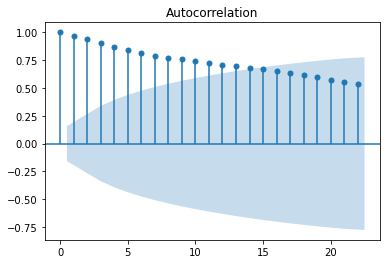

In [71]:
plot_acf(df_model);

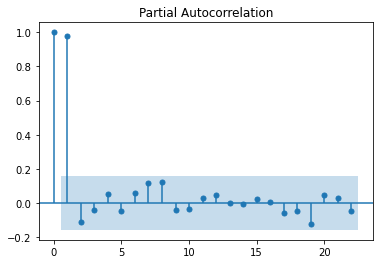

In [72]:
plot_pacf(df_model);

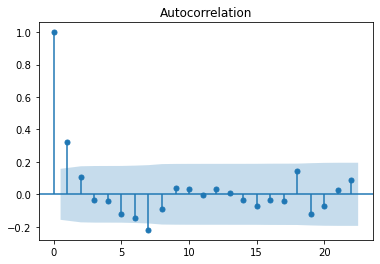

In [73]:
plot_acf(df_diff);

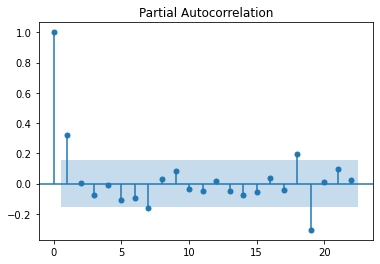

In [74]:
plot_pacf(df_diff);

### ACF plot is clearly showing, time series observations are heavily impacted by past values. While PACF is showing limited number of spikes before cut-off

# Can select AR(1) and MA(1) process to build ARIMA model

### splittng time series into training and testing sets

In [75]:
train_end=datetime(1992,12,31)
test_end=datetime(1993,12,31)

In [76]:
train             = df_model[:train_end] 
test              = df_model[train_end + timedelta(days=1):test_end]

In [77]:
train.shape

(144, 1)

# building ARIMA model

In [78]:
# model=ARMA(train,(1,1,1))
model = ARIMA(train['Price'], order=(1,1,1))

# mod = ARIMA(train_final['Volume'], order=(1,0,2))

results_Arima = model.fit()

print(results_Arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -506.540
Method:                       css-mle   S.D. of innovations              8.355
Date:                Sat, 20 Mar 2021   AIC                           1021.080
Time:                        23:22:11   BIC                           1032.932
Sample:                    02-28-1981   HQIC                          1025.896
                         - 12-31-1992                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8818      1.038      0.850      0.395      -1.152       2.915
ar.L1.D.Price     0.3328      0.198      1.679      0.093      -0.056       0.721
ma.L1.D.Price    -0.0059      0.205     

In [79]:
model_fit=model.fit()

In [80]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -506.540
Method:                       css-mle   S.D. of innovations              8.355
Date:                Sat, 20 Mar 2021   AIC                           1021.080
Time:                        23:22:22   BIC                           1032.932
Sample:                    02-28-1981   HQIC                          1025.896
                         - 12-31-1992                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8818      1.038      0.850      0.395      -1.152       2.915
ar.L1.D.Price     0.3328      0.198      1.679      0.093      -0.056       0.721
ma.L1.D.Price    -0.0059      0.205     

### predicting forecasts using the model

In [81]:
pred_start=test.index[0]
pred_end=test.index[-1]

In [82]:
pred_end

Timestamp('1993-12-31 00:00:00')

In [83]:
forecast=model_fit.forecast(12)

In [84]:
forecast

(array([196.18284726, 196.51916224, 197.21942576, 198.04082549,
        198.90254406, 199.77768231, 200.65728715, 201.53837865,
        202.41996495, 203.30171596, 204.18352178, 205.06534584]),
 array([ 8.35536152, 13.88293014, 18.34795636, 22.088722  , 25.33107901,
        28.21786704, 30.84007256, 33.25754923, 35.51126389, 37.63037856,
        39.63640155, 41.54569051]),
 array([[179.80663961, 212.55905491],
        [169.30911917, 223.72920531],
        [161.2580921 , 233.18075941],
        [154.7477259 , 241.33392508],
        [149.25454152, 248.5505466 ],
        [144.47167919, 255.08368544],
        [140.21185566, 261.10271864],
        [136.35477994, 266.72197735],
        [132.81916668, 272.02076323],
        [129.54752926, 277.05590266],
        [126.49760227, 281.86944129],
        [123.63728874, 286.49340295]]))

In [85]:
##predictions=model_fit.predict(start=pred_start, end=pred_end)


In [86]:
##predictions

### lets plot actual series and forecast

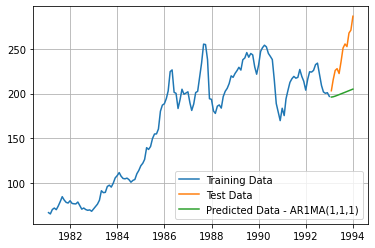

In [87]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,forecast[0],label='Predicted Data - AR1MA(1,1,1)')
plt.legend(loc='best')
plt.grid();

### finding residuals

In [88]:
residuals = test.Price - forecast[0]

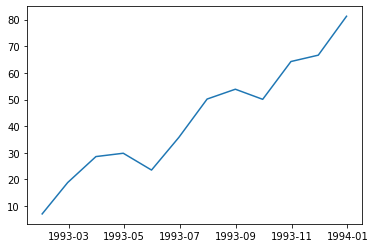

In [89]:
plt.plot(residuals)
plt.show()

### accuracy matrix

In [90]:
from sklearn.metrics import mean_squared_error

In [91]:
mean_squared_error(test.values,forecast[0],squared=False)

47.48987585490956

In [92]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

In [93]:
MAPE(test.values,forecast[0])

16.71487142822713

### residual q-q plot for to check model performance 

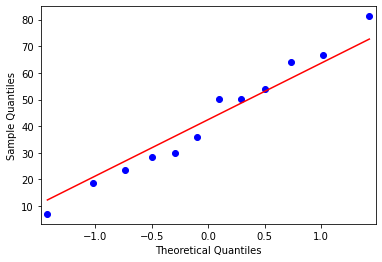

In [94]:
qqplot(residuals,line="s");

## forecast

In [96]:
model=ARIMA(df_model, order=(1,1,1))

In [97]:
model_fit=model.fit()

In [99]:
forecast=model_fit.forecast(12)[0]

In [107]:
forecasting=pd.DataFrame(forecast)

In [112]:
date = pd.date_range(start='01/01/1994', end='31/12/1994',periods=12)
forecasting['timestamp']=date
forecasting=forecasting.set_index('timestamp')
forecasting

,0
timestamp,
1994-01-01 00:00:00.000000000,292.351254
1994-02-03 02:10:54.545454545,295.315963
1994-03-08 04:21:49.090909091,297.268325
1994-04-10 06:32:43.636363636,298.884293
1994-05-13 08:43:38.181818182,300.388479
1994-06-15 10:54:32.727272728,301.855521
1994-07-18 13:05:27.272727272,303.310220
1994-08-20 15:16:21.818181820,304.760818
1994-09-22 17:27:16.363636364,306.210052


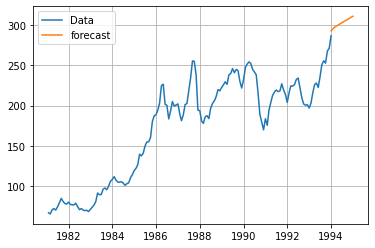

In [113]:
plt.plot(df_model,label='Data')
plt.plot(forecasting,label='forecast')
plt.legend(loc='best')
plt.grid();

# End